In [22]:
import os
import pandas as pd
import requests
import time
import sys
import numpy as np
import csv
import datetime
import osmnx as ox
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import networkx as nx
import pandana as pdna
import geopandas as gpd
import ast

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from delhi_ambulance_study import gis_util, util

In [3]:
DATA_FOLDER = os.path.join('..', 'data')
with open(os.path.join(DATA_FOLDER, 'keys.csv'), 'r') as f:
    keys = csv.reader(f)
    keys = list(keys)[0]
    
API_KEY = keys[0]
%matplotlib inline

# Hospital Locations

Using RML, Indu Rao,Amarindu, AIIMS, Sushrut, Deen Dayal Upadhyaya, Safdarjung, Lal bahadur shastry, GTB as the list of hospitals in Delhi, **(There is no hospital by the name Amarindu)**

In [9]:
df_delhi_hospitals = pd.DataFrame({'name': ['Ram Manohar Lohia Hospital',
                                            'North DMC Medical College & Hindu Rao Hospital',
                                            'AIIMS',
                                            'Sushrut Trauma Centre',
                                            'Deen Dayal Upadhyay Hospital',
                                            'Safdarjung Hospital',
                                            'Lal Bahadur Shastri Hospital',
                                            'GTB Hospital'
                                           ],
                                   'street': ['Baba Kharak Singh Marg',
                                              'DR. J.S. Kkaranwal Memorial Road',
                                              'Safdarjung Enclave, Aurobindo Marg, Ansari Nagar',
                                              'Ring Road, Behind I.P. College, Near Civil Lines Metro Station, Metcalf Road',
                                              'Clock Tower Chowk, Hari Enclave',
                                              'Safdarjung Campus',
                                              'Near Kalyanvas Colony, Mayur Vihar, Phase -II',
                                              'GTB Enclave'
                                              
                                             ],
                                   'neighbourhood': ['Connaught Place',
                                                   'Malka Ganj',
                                                   'Haus Khas',
                                                   'Civil Lines',
                                                   'Hari Nagar',
                                                   'Ansari Nagar West',
                                                   'Khichripur',
                                                   'Shahdara'],
                                   'city': ['New Delhi',
                                            'New Delhi',
                                            'New Delhi',
                                            'New Delhi',
                                            'New Delhi',
                                            'New Delhi',
                                            'New Delhi',
                                            'New Delhi'
                                           ],
                                   'state': ['Delhi',
                                             'Delhi',
                                             'Delhi',
                                             'Delhi',
                                             'Delhi',
                                             'Delhi',
                                             'Delhi',
                                             'Delhi'
                                            ],
                                   'pin': ['110001',
                                           '110007',
                                           '110029',
                                           '110054',
                                           '110064',
                                           '110029',
                                           '110091',
                                           '110095'
                                          ],
                                   'country': ['India',
                                               'India',
                                               'India',
                                               'India',
                                               'India',
                                               'India',
                                               'India',
                                               'India'
                                             ]
                                  })

In [10]:
addresses = list((df_delhi_hospitals['name'] + ',' + df_delhi_hospitals['street'] + ',' + df_delhi_hospitals['neighbourhood'] + ',' + df_delhi_hospitals['city'] + ',' + df_delhi_hospitals['state'] + ' ' + df_delhi_hospitals['pin'] + "," + df_delhi_hospitals['country']))

Geocoding using Google geocoding API,

In [13]:
results = gis_util.batch_geocode(addresses, DATA_FOLDER, 'delhi_hospitals_latlong.csv', API_KEY)

Geocoded: Ram Manohar Lohia Hospital,Baba Kharak Singh Marg,Connaught Place,New Delhi,Delhi 110001,India: OK
Geocoded: North DMC Medical College & Hindu Rao Hospital,DR. J.S. Kkaranwal Memorial Road,Malka Ganj,New Delhi,Delhi 110007,India: OK
Geocoded: AIIMS,Safdarjung Enclave, Aurobindo Marg, Ansari Nagar,Haus Khas,New Delhi,Delhi 110029,India: OK
Geocoded: Sushrut Trauma Centre,Ring Road, Behind I.P. College, Near Civil Lines Metro Station, Metcalf Road,Civil Lines,New Delhi,Delhi 110054,India: OK
Geocoded: Deen Dayal Upadhyay Hospital,Clock Tower Chowk, Hari Enclave,Hari Nagar,New Delhi,Delhi 110064,India: OK
Geocoded: Safdarjung Hospital,Safdarjung Campus,Ansari Nagar West,New Delhi,Delhi 110029,India: OK
Geocoded: Lal Bahadur Shastri Hospital,Near Kalyanvas Colony, Mayur Vihar, Phase -II,Khichripur,New Delhi,Delhi 110091,India: OK
Geocoded: GTB Hospital,GTB Enclave,Shahdara,New Delhi,Delhi 110095,India: OK


In [14]:
df_delhi_hospitals = df_delhi_hospitals.iloc[[results.index(entry) for entry in results if entry['status'] == 'OK']]

In [15]:
df_delhi_hospitals['lat'] = [entry['latitude'] for entry in results if entry['status'] == 'OK']
df_delhi_hospitals['lng'] = [entry['longitude'] for entry in results if entry['status'] == 'OK']

In [26]:
df_delhi_hospitals['hosp_id'] = range(1, df_delhi_hospitals.shape[0] + 1)

In [27]:
df_delhi_hospitals.to_csv(os.path.join(DATA_FOLDER, 'delhi_hospitals_final_geocoded.csv'), index=False)

In [28]:
df_delhi_hospitals

,city,country,name,neighbourhood,pin,state,street,lat,lng,hosp_id
0,New Delhi,India,Ram Manohar Lohia Hospital,Connaught Place,110001,Delhi,Baba Kharak Singh Marg,28.627123,77.207337,1
1,New Delhi,India,North DMC Medical College & Hindu Rao Hospital,Malka Ganj,110007,Delhi,DR. J.S. Kkaranwal Memorial Road,28.650374,77.182668,2
2,New Delhi,India,AIIMS,Haus Khas,110029,Delhi,"Safdarjung Enclave, Aurobindo Marg, Ansari Nagar",28.566827,77.208120,3
3,New Delhi,India,Sushrut Trauma Centre,Civil Lines,110054,Delhi,"Ring Road, Behind I.P. College, Near Civil Lin...",28.679779,77.228379,4
4,New Delhi,India,Deen Dayal Upadhyay Hospital,Hari Nagar,110064,Delhi,"Clock Tower Chowk, Hari Enclave",28.628012,77.112397,5
5,New Delhi,India,Safdarjung Hospital,Ansari Nagar West,110029,Delhi,Safdarjung Campus,28.567839,77.205795,6
6,New Delhi,India,Lal Bahadur Shastri Hospital,Khichripur,110091,Delhi,"Near Kalyanvas Colony, Mayur Vihar, Phase -II",28.617721,77.311242,7
7,New Delhi,India,GTB Hospital,Shahdara,110095,Delhi,GTB Enclave,28.683812,77.311004,8


# Crash & taxi Locations

## Real data availability assumptions

* This study's geographical area of interest spans the entire National Capital Region, which is comprised of a number of districts in Haryana, Rajasthan and Uttar Pradesh along with the National Capital Territory of Delhi. 
* Taxi location data is supposed to include log information of Delhi taxis reported at a frequency of 1 minute, spanning the entire duration of the study, which is [(12 am, 1st January 2016), (12 am, 1st January 2017))
* Crash information is sourced from fatal road accidents data in NCR for the year 2017. This dataset is supposed to have about 2000 records. 

## Simulated Data

* To avoid prohibitively long computation times, the simulated crash dataset will have only 100 records, with timepoints anywhere in [(12 am, 1st January 2016), (12 am, 1st January 2017))
* Simulated data for taxi locations will have 1 log for 10000 taxis for [(12 am, 30th December 2015), (12 am, 1st January 2016)).
* All events in this dataset will be from within the National Capital Territory of Delhi and not the whole NCR.

Using 'as the crow flies' distance to get the closest taxes from crash location will result in data that is not representative of actual travel distances. We need information on the road network. This study uses Open Street Map (OSM)'s road network information. This is accomplished with [osmnx](https://github.com/gboeing/osmnx), a Python package that does API calls to OSM API. We do not directly use Google Directions API, which has the capability to give estimated travel times based on time of the day, as other factors such as API call latency for each query and daily quota mean that we must restrict the number of these queries to as small as possible. An advantage of osmnx is that there will be only one OSM API call, when the entire road network dataset will be downloaded, and all shortest distance computations will be local.

In [ ]:
# dctlst_places = [ {'state':'National Capital Territory', 'country':'India'},
#                 {'district': 'Meerut', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Muzzafarnagar', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Ghaziabad', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Gautam Budh Nagar', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Bulandshahr', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Baghpat', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Hapur', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Shamli', 'state':'Uttar Pradesh', 'country':'India'},
#                 {'district': 'Faridabad', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Gurugram', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Mahendragarh', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Bhiwani', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Charkhi Dhadri', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Nuh', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Rohtak', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Sonipat', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Rewari', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Jhajjar', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Panipat', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Palwal', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Jind', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Karnal', 'state': 'Haryana', 'country': 'India'},
#                 {'district': 'Alwar', 'state': 'Rajasthan', 'country': 'India'},
#                 {'district': 'Bharatpur', 'state': 'Rajasthan', 'country': 'India'}
#                 ]

dctlst_places = [ {'state':'National Capital Territory', 'country':'India'}]

ncr_roads = ox.graph_from_place(place_names, network_type='drive_service')

We then proceed wit the download of NCR road network. We can save this as shape files. This will create two folders, Nodes and Edges. Edges have information on road segments and Nodes can be thought of as (lat, long) points that mark curves, intersections, etc., that is essential to reconstruct the roads. Since we will use these points as possible candidate locations for crashes and taxis, we also create a csv version of edges.

In [ ]:
ncr_network = gis_util.get_street_network(dctlst_places, DATA_FOLDER, 'ncr')
ncr_network = ox.load_graphml(filename='ncr.graphml', folder=os.path.join(DATA_FOLDER, 'ncr'))

gdf_ncr = gpd.read_file(os.path.join(DATA_FOLDER, 'ncr', 'nodes', 'nodes.shp'))

gdf_ncr.to_csv(os.path.join(DATA_FOLDER, 'ncr', 'ncr.csv'))

In [22]:
df_delhi_points = pd.read_csv(os.path.join(DATA_FOLDER, 'ncr', 'ncr.csv'), index_col=0)

In [23]:
df_delhi_points.columns

Index(['highway', 'lat', 'lon', 'osmid', 'ref', 'geometry'], dtype='object')

Creating crash data with 2000 random points (with replacement) from the nodes csv and 2000 time points in 2016,

In [29]:
crash_loc_indices = np.random.choice(df_delhi_points.index, size=2000, replace=True)

In [30]:
time_points = pd.date_range(start='2016-01-01 00:00:00', end='2017-01-01 00:00:00', freq='15min', tz='Asia/Kolkata')

In [31]:
df_crash_events = pd.DataFrame({'event_time': np.random.choice(time_points, size=2000, replace=True), 
              'event_lat': df_delhi_points.iloc[crash_loc_indices]['lat'],
              'event_lng': df_delhi_points.iloc[crash_loc_indices]['lon']
             })

Localising the timepoints to IST,

In [33]:
df_crash_events['event_time'] = pd.to_datetime(df_crash_events['event_time']).dt.tz_localize('Asia/Kolkata')

In [34]:
df_crash_events.to_csv(os.path.join(DATA_FOLDER, 'crashes.csv'), index=False)

Creating 10000 taxis and creating one log entry for each them at a random time point (with replacement) in [(12 am, 30th December 2015), (12 am, 1st January 2016)), with 10000 random locations chosen from edges csv file with replacement,

In [36]:
taxi_loc_indices = np.random.choice(df_delhi_points.index, size=10000, replace=True)
time_points = pd.date_range(start='2015-12-29 00:00:00', end='2015-12-31 23:59:00', freq='0.5min', tz='Asia/Kolkata')
df_taxi_log = pd.DataFrame({'log_id': range(1, 10001),
                            'taxi_id': range(1, 10001),
                            'log_time': np.random.choice(time_points, size=10000, replace=True), 
                            'log_lat': df_delhi_points.iloc[taxi_loc_indices]['lat'],
                            'log_lng': df_delhi_points.iloc[taxi_loc_indices]['lon']
                            })
df_taxi_log['log_time'] = pd.to_datetime(df_taxi_log['log_time']).dt.tz_localize('Asia/Kolkata')
df_taxi_log['log_on_call'] = True

Since each taxi is assumed to have numerous logs, and it makes sense to restrict it to taxis which are available for hire, we introduce the following fields:

* log_id - Uniquely identify each log. Helps keep track of multiple spatiotemporal logs for each taxi.
* log_on_call - To denote the taxi's availability

In [37]:
df_taxi_log.to_csv(os.path.join(DATA_FOLDER, 'taxi_log.csv'), index=False)

# Getting closest hospital & taxi information

Loading all the files created in the steps above,

In [4]:
df_delhi_hospitals = pd.read_csv(os.path.join(DATA_FOLDER, 'delhi_hospitals_final_geocoded.csv'))
df_crash_events = pd.read_csv(os.path.join(DATA_FOLDER, 'crashes.csv'))
df_taxi_log = pd.read_csv(os.path.join(DATA_FOLDER, 'taxi_log.csv'))


df_taxi_log['log_time'] = pd.to_datetime(df_taxi_log['log_time']).dt.tz_localize('UTC').dt.tz_convert(
    'Asia/Kolkata')
df_crash_events['event_time'] = pd.to_datetime(df_crash_events['event_time']).dt.tz_localize(
    'UTC').dt.tz_convert('Asia/Kolkata')

ncr_network = ox.load_graphml(filename='ncr.graphml', folder=os.path.join(DATA_FOLDER, 'ncr'))

gdf_ncr = gpd.read_file(os.path.join(DATA_FOLDER, 'ncr', 'nodes', 'nodes.shp'))

Our problem, finding closest taxis and hospitals to crash locations, is similar to the modified closest pair of points. We have two sets (Crashes, Hospitals) or (Crashes, Taxis), and our prerogative is to match each point in set A (Crashes) with the closest point in set B (Hospitals or Taxis). Naive approaches will mean there will be (nCrash X nHospital + nCrash X nTaxi) computations. 

In order to reduce the number of computations, we make use of [Pandana](https://github.com/UDST/pandana), which makes use of efficient closest pair calculation algorithms for netowork related queries like ours. A noteworthy feature of Pandana is its general network level aggregations. The impication is that there will only be a single query (1 each for taxi and hospital) for each crash, on the aggregated list of closest points of interest to each node. This aggregated list can be thought of a list of all nodes in the network, along with information on k closest points of interest to each of them. These points of interest can be hospitals or taxi locations.

Let us visualise information on roads provided by OSM.

In [5]:
gdf_nodes = ox.graph_to_gdfs(ncr_network, edges=False)
gdf_edges = ox.graph_to_gdfs(ncr_network, nodes=False)

In [6]:
gdf_edges

,access,area,bridge,geometry,highway,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,NaN,"LINESTRING (77.1680173 28.5426036, 77.16793149...",residential,0,NaN,NaN,62.355284,NaN,NaN,False,7892104,NaN,NaN,NaN,58047704,58047707,NaN
1,NaN,NaN,NaN,"LINESTRING (77.16769119999999 28.5430787, 77.1...",residential,0,NaN,NaN,64.212083,NaN,NaN,False,7892369,NaN,NaN,NaN,58047707,58051020,NaN
2,NaN,NaN,NaN,"LINESTRING (77.16769119999999 28.5430787, 77.1...",residential,0,NaN,NaN,62.355284,NaN,NaN,False,7892104,NaN,NaN,NaN,58047707,58047704,NaN
3,NaN,NaN,NaN,"LINESTRING (77.16769119999999 28.5430787, 77.1...",residential,0,NaN,NaN,23.925042,NaN,NaN,False,7892369,NaN,NaN,NaN,58047707,2265700198,NaN
4,NaN,NaN,NaN,"LINESTRING (77.16437809999999 28.5383963, 77.1...",residential,0,NaN,NaN,48.454379,NaN,JNU Ring Road,False,7892285,NaN,NaN,NaN,58049717,4231408578,NaN
5,NaN,NaN,NaN,"LINESTRING (77.16437809999999 28.5383963, 77.1...",residential,0,NaN,NaN,54.288460,NaN,NaN,False,44676786,NaN,NaN,NaN,58049717,566995342,NaN
6,NaN,NaN,NaN,"LINESTRING (77.16437809999999 28.5383963, 77.1...",residential,0,NaN,NaN,26.511984,NaN,NaN,False,44676786,NaN,NaN,NaN,58049717,58049748,NaN
7,NaN,NaN,NaN,"LINESTRING (77.1646356 28.5389618, 77.1647214 ...",residential,0,NaN,NaN,45.217080,NaN,JNU Ring Road,False,7892285,NaN,NaN,NaN,58049718,58049719,NaN
8,NaN,NaN,NaN,"LINESTRING (77.1646356 28.5389618, 77.1645623 ...",residential,0,NaN,NaN,19.270957,NaN,JNU Ring Road,False,7892285,NaN,NaN,NaN,58049718,4231408578,NaN
9,NaN,NaN,NaN,"LINESTRING (77.1646356 28.5389618, 77.1637667 ...",residential,0,NaN,NaN,203.142993,NaN,NaN,False,423558219,NaN,NaN,NaN,58049718,4231408572,NaN


Closest pair of points in graphs (network) use weights (impedences) on nodes as the flavour in which they are close; the flavour in our case is distance or time taken to travel. Distance alone cannot give a true estimate of required time, since a trip that makes use of too many short side lanes can be slower than a longer path on an expressway. Speed limit thus is a valuable information. This however is not available for this road network. We however can mimic this by assigning limits based on the type of the segments. This can then be used to weight the edges. Checking the types of road segments present,

In [7]:
gdf_edges['highway'] = list(map(str, gdf_edges['highway']))

In [13]:
gdf_edges['highway'].unique()

array(['residential', 'secondary', 'primary', 'primary_link', 'tertiary',
       'unclassified', 'tertiary_link', 'service', 'trunk_link', 'trunk',
       'secondary_link', 'living_street', "['service', 'secondary']",
       'motorway', 'motorway_link', "['residential', 'service']",
       "['unclassified', 'residential']", "['residential', 'tertiary']",
       "['tertiary', 'secondary']", "['residential', 'living_street']",
       "['secondary', 'primary']", "['trunk', 'trunk_link']",
       "['trunk', 'secondary']", "['tertiary', 'trunk_link']",
       "['secondary_link', 'primary']", "['primary_link', 'secondary']",
       "['unclassified', 'service']", "['unclassified', 'tertiary']",
       "['secondary_link', 'secondary']", "['service', 'living_street']",
       "['unclassified', 'living_street']", "['tertiary', 'road']",
       'road'], dtype=object)

In [9]:
gdf_edges['maxspeed'] = list(map(util.tidy_maxspeed_tuple_to_int, gdf_edges['maxspeed']))

Some road segments do have max speed information.

In [10]:
gdf_edges.loc[gdf_edges['maxspeed'].notnull()]

,access,area,bridge,geometry,highway,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
241,NaN,NaN,NaN,"LINESTRING (77.2388844 28.5780587, 77.2388935 ...",residential,0,NaN,NaN,302.863721,20.0,Prachin Shiv Mandir Road,False,38116089,NaN,NaN,NaN,250100205,250100312,NaN
266,NaN,NaN,NaN,"LINESTRING (77.24312279999999 28.57865, 77.241...",residential,0,NaN,NaN,168.725184,20.0,Prachin Shiv Mandir Road,False,38116089,NaN,NaN,NaN,250100307,250100312,NaN
268,NaN,NaN,NaN,"LINESTRING (77.24312279999999 28.57865, 77.245...",residential,0,NaN,NaN,682.872896,20.0,Prachin Shiv Mandir Road,False,38116089,NaN,NaN,NaN,250100307,448444374,NaN
270,NaN,NaN,NaN,"LINESTRING (77.2413954 28.5786133, 77.24312279...",residential,0,NaN,NaN,168.725184,20.0,Prachin Shiv Mandir Road,False,38116089,NaN,NaN,NaN,250100312,250100307,NaN
272,NaN,NaN,NaN,"LINESTRING (77.2413954 28.5786133, 77.2413382 ...",residential,0,NaN,NaN,302.863721,20.0,Prachin Shiv Mandir Road,False,38116089,NaN,NaN,NaN,250100312,250100205,NaN
344,NaN,NaN,NaN,"LINESTRING (77.1200992 28.4794161, 77.1208094 ...",trunk,0,NaN,2,529.470535,50.0,Anuvrat Marg,True,266776805,NH236,NaN,NaN,251691490,251691498,NaN
346,NaN,NaN,NaN,"LINESTRING (77.1249404 28.4800871, 77.12485820...",trunk,0,NaN,2,548.092595,50.0,Mehrauli Gurgaon Road,True,42944885,NH236,NaN,NaN,251691498,1874201419,NaN
347,NaN,NaN,NaN,"LINESTRING (77.1249404 28.4800871, 77.1250556 ...",trunk,0,NaN,2,644.920401,50.0,Anuvrat Marg,True,266776805,NH236,NaN,NaN,251691498,314356599,NaN
349,NaN,NaN,NaN,"LINESTRING (77.13515289999999 28.4876748, 77.1...",trunk,0,NaN,2,143.033800,50.0,Anuvrat Marg,True,266776805,NH236,NaN,NaN,251691508,2507510499,NaN
351,NaN,NaN,NaN,"LINESTRING (77.1388133 28.4894306, 77.13981510...",trunk,0,NaN,2,134.572022,50.0,Anuvrat Marg,True,266776805,NH236,NaN,NaN,251691509,4154369627,NaN


Getting the minimum maxspeed for each category of highways,

In [15]:
dct_min_speed_by_category = dict(gdf_edges.loc[gdf_edges['maxspeed'].notnull()].groupby('highway')['maxspeed'].min())
dct_min_speed_by_category

{"['residential', 'service']": 30.0,
 "['secondary', 'primary']": 40.0,
 "['trunk', 'secondary']": 40.0,
 "['trunk', 'trunk_link']": 40.0,
 "['unclassified', 'tertiary']": 20.0,
 'living_street': 10.0,
 'motorway': 40.0,
 'motorway_link': 40.0,
 'primary': 40.0,
 'primary_link': 40.0,
 'residential': 10.0,
 'secondary': 20.0,
 'service': 20.0,
 'tertiary': 20.0,
 'tertiary_link': 30.0,
 'trunk': 40.0,
 'trunk_link': 60.0,
 'unclassified': 20.0}

Since we already have representative lowerbound speed limits for each of the categories, we can use this to impute the missing speed limits. Assuming the worst case, I proceed to replace missing maxspeed values with the least maxspeed value seen for that particular category.

In [29]:
for idx, row in gdf_edges.loc[gdf_edges['maxspeed'].isnull()].iterrows():
    maxspeed = dct_min_speed_by_category.get(row['highway'], np.nan)
    if math.isnan(maxspeed):
        try:
            combo_types = ast.literal_eval(row['highway'])
            maxspeed = min([speed for speed in [dct_min_speed_by_category.get(highwaytype, np.nan) for highwaytype in combo_types] if not math.isnan(speed)])
            
        except:
            pass
            
    gdf_edges.loc[idx, 'maxspeed'] = maxspeed

In [30]:
gdf_edges.loc[gdf_edges['maxspeed'].isnull()]['highway'].unique()

array(['road'], dtype=object)

Since primary_link has a speed limit of 40 and tertiary_link 30, we can fix secondary_link to a limit of 35.

In [21]:
dct_min_speed_by_category['secondary_link'] = 35
gdf_edges.loc[gdf_edges['highway'] == 'secondary_link', 'maxspeed'] = 35

Since the rest of the segments are types, let us assign the lowest limit possible based on the types in the combo. For example, for an [A, B], let us assign min(min(A), min(B))

Road is the only type that has no maxspeed. Let us investigate what these segments usually mean.

In [33]:
gdf_edges.loc[gdf_edges['highway'] == 'road', 'name'].unique()

array([nan, 'Upper gali'], dtype=object)

'Gali' is Hindi equivalent of street, but not as broad as the Hindi designation for broad streets, पथ (transliterated as 'path'). Also, OSM uses 'road' for a varied classification of path segments. So this is possibly a non homogeneous set. For this reason, I am assigning it a level higher than the lowest designation, residential, assigning it a maxspeed of 15. I do not assign it the lowermost designation, as that would mean that residential segments would then have the same preference as roads.

In [34]:
dct_min_speed_by_category['road'] = 15
gdf_edges.loc[gdf_edges['highway'] == 'road', 'maxspeed'] = 15

Let us construct the time taken to traverse weights,

In [36]:
gdf_edges['time_to_traverse'] = gdf_edges['length']/ gdf_edges['maxspeed']

We are now all set to proceed with setting up a Pandana network. We use this network for network related queries such as closest hospital and taxis from crash nodes.

In [37]:
twoway = list(~gdf_edges["oneway"].values)
ncr_net=pdna.Network(gdf_nodes["x"], gdf_nodes["y"], gdf_edges["u"], gdf_edges["v"],
                 gdf_edges[["time_to_traverse"]], twoway=twoway)

## Closest Pair matching computation

Pandanas allows aggregated network information related queries on road networks with custom points by allowing new 'points of interest' overlayed on the base network. Closest node without any impedence to each of these 'points of interests' are determined, and these base nodes will then be used to compute distances from other nodes with impedence. For example, say we have a POI 'XYZ Hospital' to be added to Delhi network. Pandanas would choose the closest 'as the crow flies' node to this POI and assign this node as this POI's home node. Then, each of the other nodes' distance from it will be calculated from this node, taking account of usual impedences, such as length or maxspeed of edges connecting them. Expanding this to a list of POIs, pandana's one feature is to compute an aggregated list table for all nodes with k closest POIs to them. This table can be used to get closest POIs (say hospitals) from our nodes of interest, (say crash locations)

In [120]:
delhi_net.set_pois("hospitals", 1000000, 3, df_delhi_hospitals['lng'], df_delhi_hospitals['lat'])

In [13]:
df_delhi_hospitals.iloc[26,]

State                                                        Delhi
District                                                     South
Facility Name         Delhi Government Ayush Dispensary, Ber Sarai
Contact          Delhi Administration Dispensary Building, Sout...
lat                                                         28.549
lng                                                        77.1827
id                                                              27
Name: 26, dtype: object

In [34]:
gdf_nodes.loc[gdf_nodes['osmid']=='58056528',]

,highway,osmid,ref,x,y,geometry
58056528,NaN,58056528,NaN,77.171,28.5594,POINT (77.1710004 28.5593895)


In [91]:
delhi_net_sub = delhi_net

In [51]:
n = 10
lst_taxi_id = np.random.choice(df_taxi_log['taxi_id'], size=n, replace=False)

In [83]:
t = df_crash_events.iloc[1,]['event_time'] 

In [123]:
t = delhi_net.nearest_pois(1000000, "hospitals", num_pois=2, imp_name='length', include_poi_ids=True)

In [127]:
t.index

Int64Index([  58047704,   58047707,   58049717,   58049718,   58049719,
              58049720,   58049722,   58049725,   58049728,   58049730,
            ...
            5381367481, 5381367484, 5381367485, 5381367488, 5381367519,
            5381367520, 5381373122, 5381373123, 5389934469, 5389934474],
           dtype='int64', length=120652)

In [134]:
t.loc[58047704,]['poi1']

26.0

In [137]:
n = 10
np.random.choice(df_taxi_log['taxi_id'], size=n, replace=False)
lst_taxis = []
lst_hospitals = []
for idx, row in df_crash_events.iterrows():
    orig_lat = row['event_lat']
    orig_lng = row['event_lng']
    crash_node = ox.utils.get_nearest_node(delhi_network, (orig_lat, orig_lng))
    print(crash_node)
    df_curr_taxi = df_taxi_log.loc[(df_taxi_log['taxi_id'].isin(lst_taxi_id)) & (df_taxi_log['log_time'] <= row['event_time']),].sort_values(by='log_time', ascending=False).groupby('taxi_id').first().reset_index()
    delhi_net_sub = delhi_net
    delhi_net_sub.set_pois("taxis", 1000000, 3, df_curr_taxi['log_lng'], df_curr_taxi['log_lat'])
    
    df_nearest_taxis = delhi_net_sub.nearest_pois(1000000, "taxis", num_pois=3, imp_name='length', include_poi_ids=True)
    
    nearest_taxis = df_nearest_taxis.loc[crash_node,]
    
    print(nearest_taxis)
    
    lst_taxis.append([nearest_taxis['poi1'], nearest_taxis['poi2'], nearest_taxis['poi3']])
    
    df_nearest_hospitals = delhi_net_sub.nearest_pois(1000000, "hospitals", num_pois=2, imp_name='length', include_poi_ids=True)
                          
    nearest_hospitals = df_nearest_hospitals.loc[crash_node,]
    print(nearest_hospitals)
    lst_hospitals.append([nearest_hospitals['poi1'], nearest_hospitals['poi2']])

906761726
1        6871.486816
2       13475.923828
3       13522.347656
poi1        5.000000
poi2        1.000000
poi3        6.000000
Name: 906761726, dtype: float64
1       3194.562012
2       3325.385986
poi1     103.000000
poi2     205.000000
Name: 906761726, dtype: float64
4068586587
1       19914.216797
2       26286.632812
3       30969.343750
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4068586587, dtype: float64
1       15161.273438
2       15229.000977
poi1      158.000000
poi2       81.000000
Name: 4068586587, dtype: float64
4229549574
1       4560.490234
2       5419.354004
3       7187.172852
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4229549574, dtype: float64
1       1998.819946
2       1998.819946
poi1     177.000000
poi2     178.000000
Name: 4229549574, dtype: float64
4221291336
1       11591.917969
2       12169.722656
3       12387.340820
poi1        3.000000
poi2        0.000000
poi3        7.000000
Name: 4221291336, d

1       10958.338867
2       11899.421875
3       11977.321289
poi1        7.000000
poi2        9.000000
poi3        3.000000
Name: 920937574, dtype: float64
1       2671.370117
2       3890.072021
poi1      15.000000
poi2       1.000000
Name: 920937574, dtype: float64
4231594316
1       1413.751953
2       2880.635010
3       4034.391113
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4231594316, dtype: float64
1       1662.569946
2       1711.302979
poi1      86.000000
poi2     177.000000
Name: 4231594316, dtype: float64
1826969338
1       4344.490234
2       5887.190918
3       8267.422852
poi1       7.000000
poi2       3.000000
poi3       0.000000
Name: 1826969338, dtype: float64
1       5942.839844
2       6851.984863
poi1       1.000000
poi2     115.000000
Name: 1826969338, dtype: float64
2225539459
1       2841.999023
2       4659.476074
3       4751.809082
poi1       0.000000
poi2       3.000000
poi3       9.000000
Name: 2225539459, dtype: float64
1       6350

1       7418.881836
2       8235.016602
3       9160.884766
poi1       9.000000
poi2       3.000000
poi3       0.000000
Name: 1826143531, dtype: float64
1        495.446991
2       1197.644043
poi1     116.000000
poi2     126.000000
Name: 1826143531, dtype: float64
1827074126
1        8179.500977
2        9041.847656
3       11080.111328
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 1827074126, dtype: float64
1       2154.547119
2       2154.547119
poi1      48.000000
poi2     108.000000
Name: 1827074126, dtype: float64
4221208158
1       2488.129883
2       3882.701904
3       9953.142578
poi1       1.000000
poi2       4.000000
poi3       5.000000
Name: 4221208158, dtype: float64
1       1659.920044
2       5148.622070
poi1      46.000000
poi2      87.000000
Name: 4221208158, dtype: float64
1349092037
1        7451.293945
2       10281.307617
3       11021.085938
poi1        5.000000
poi2        1.000000
poi3        4.000000
Name: 1349092037, dtype: float64
1   

1       10431.922852
2       12132.499023
3       14570.414062
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4233845282, dtype: float64
1        778.254028
2       1725.047974
poi1     124.000000
poi2      10.000000
Name: 4233845282, dtype: float64
4230177894
1        2627.495117
2       11338.780273
3       12738.208008
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4230177894, dtype: float64
1       443.838989
2       621.622986
poi1    208.000000
poi2     94.000000
Name: 4230177894, dtype: float64
4169308754
1        9974.557617
2       18499.412109
3       21029.685547
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4169308754, dtype: float64
1       4279.354004
2       6659.950195
poi1      81.000000
poi2     127.000000
Name: 4169308754, dtype: float64
4217352638
1       10828.888672
2       12480.980469
3       21822.468750
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4217352638, dtype: floa

4216796918
1        8312.963867
2       23226.144531
3       23677.667969
poi1        6.000000
poi2        2.000000
poi3        5.000000
Name: 4216796918, dtype: float64
1       9122.597656
2       9257.536133
poi1     196.000000
poi2     121.000000
Name: 4216796918, dtype: float64
1826378222
1       3171.052979
2       4640.166016
3       4913.056152
poi1       9.000000
poi2       3.000000
poi3       0.000000
Name: 1826378222, dtype: float64
1       1250.923950
2       1874.850952
poi1      86.000000
poi2      56.000000
Name: 1826378222, dtype: float64
1826378310
1       3169.658936
2       4384.332031
3       4911.662109
poi1       9.000000
poi2       3.000000
poi3       0.000000
Name: 1826378310, dtype: float64
1       1249.530029
2       1600.411987
poi1      86.000000
poi2      12.000000
Name: 1826378310, dtype: float64
4225073110
1        6506.054199
2        8322.083984
3       12817.009766
poi1        1.000000
poi2        4.000000
poi3        5.000000
Name: 4225073110, dtype: f

2000645755
1        8005.686035
2       11031.054688
3       17880.345703
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 2000645755, dtype: float64
1       2032.687012
2       2032.687012
poi1      32.000000
poi2      33.000000
Name: 2000645755, dtype: float64
4228103448
1       14641.642578
2       16295.804688
3       21879.500000
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4228103448, dtype: float64
1       8260.469727
2       8416.855469
poi1     182.000000
poi2      32.000000
Name: 4228103448, dtype: float64
4153513084
1        9647.222656
2       18017.117188
3       20702.351562
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4153513084, dtype: float64
1       4000.660889
2       6177.657227
poi1      81.000000
poi2     127.000000
Name: 4153513084, dtype: float64
921044452
1       8678.202148
2       8946.917969
3       9214.011719
poi1       9.000000
poi2       7.000000
poi3       3.000000
Name: 921044452, dtyp

1       2914.455078
2       3331.504883
3       5304.597168
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4231262844, dtype: float64
1       2514.561035
2       2514.561035
poi1     177.000000
poi2     178.000000
Name: 4231262844, dtype: float64
566995298
1        5355.651855
2       15088.061523
3       15561.587891
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 566995298, dtype: float64
1       2834.154053
2       3469.444092
poi1      26.000000
poi2     120.000000
Name: 566995298, dtype: float64
4210488390
1       1419.552002
2       7922.750000
3       8640.352539
poi1       5.000000
poi2       4.000000
poi3       1.000000
Name: 4210488390, dtype: float64
1        435.221008
2       1460.526001
poi1     165.000000
poi2      98.000000
Name: 4210488390, dtype: float64
4211813514
1         788.065002
2       10871.922852
3       20838.740234
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 4211813514, dtype: float64
1      

4223754818
1       17642.326172
2       18980.025391
3       19302.021484
poi1        7.000000
poi2        1.000000
poi3        3.000000
Name: 4223754818, dtype: float64
1       10025.547852
2       10025.547852
poi1       59.000000
poi2      179.000000
Name: 4223754818, dtype: float64
4228218115
1        752.315979
2       2482.435059
3       2850.304932
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4228218115, dtype: float64
1       2081.587891
2       2081.587891
poi1      56.000000
poi2     173.000000
Name: 4228218115, dtype: float64
2009133876
1        2867.852051
2       13924.280273
3       19775.207031
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 2009133876, dtype: float64
1       5515.397949
2       5961.097168
poi1      81.000000
poi2     120.000000
Name: 2009133876, dtype: float64
4231233977
1        1937.082031
2        9393.147461
3       14557.830078
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4231233977

4530851891
1       1364.719971
2       1948.531006
3       2950.738037
poi1       3.000000
poi2       9.000000
poi3       0.000000
Name: 4530851891, dtype: float64
1       1075.598999
2       2647.145020
poi1      18.000000
poi2      56.000000
Name: 4530851891, dtype: float64
920646028
1       10030.206055
2       10298.921875
3       10566.015625
poi1        9.000000
poi2        7.000000
poi3        3.000000
Name: 920646028, dtype: float64
1       1691.526978
2       1770.505981
poi1     172.000000
poi2     122.000000
Name: 920646028, dtype: float64
4165783854
1        5830.231934
2       16011.588867
3       22612.646484
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 4165783854, dtype: float64
1        7253.149902
2       10760.578125
poi1       81.000000
poi2       26.000000
Name: 4165783854, dtype: float64
920644692
1       10334.823242
2       10603.539062
3       10870.632812
poi1        9.000000
poi2        7.000000
poi3        3.000000
Name: 920644692, dty

1       7443.933105
2       8202.748047
3       9561.698242
poi1       0.000000
poi2       9.000000
poi3       3.000000
Name: 4228036576, dtype: float64
1       3822.003906
2       6396.201172
poi1      91.000000
poi2     177.000000
Name: 4228036576, dtype: float64
4221588732
1       14450.570312
2       16110.265625
3       18485.144531
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 4221588732, dtype: float64
1       1846.07605
2       1846.07605
poi1      59.00000
poi2     179.00000
Name: 4221588732, dtype: float64
1901091972
1        5552.545898
2       13209.650391
3       15607.349609
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 1901091972, dtype: float64
1       1313.755981
2       3095.808105
poi1     120.000000
poi2      26.000000
Name: 1901091972, dtype: float64
4230127771
1       3204.077881
2       4339.180176
3       5830.761230
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4230127771, dtype: float64
1       

1        3032.593994
2       11268.331055
3       12381.582031
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4101041335, dtype: float64
1       1068.004028
2       1326.938965
poi1      94.000000
poi2     105.000000
Name: 4101041335, dtype: float64
4228203304
1       1234.625977
2       3169.025879
3       3484.638916
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4228203304, dtype: float64
1       996.559021
2       996.559021
poi1     56.000000
poi2    173.000000
Name: 4228203304, dtype: float64
4215248800
1        9089.587891
2       13959.935547
3       17835.490234
poi1        6.000000
poi2        2.000000
poi3        5.000000
Name: 4215248800, dtype: float64
1       2580.801025
2       2909.472900
poi1     121.000000
poi2     180.000000
Name: 4215248800, dtype: float64
4221244985
1       15671.166992
2       16533.513672
3       18571.775391
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 4221244985, dtype: float64
1 

1        7650.106934
2       22138.128906
3       22589.652344
poi1        6.000000
poi2        2.000000
poi3        5.000000
Name: 2018174262, dtype: float64
1       8169.520996
2       9020.431641
poi1     121.000000
poi2     196.000000
Name: 2018174262, dtype: float64
4231822375
1        3222.331055
2       10811.393555
3       11807.807617
poi1        8.000000
poi2        9.000000
poi3        0.000000
Name: 4231822375, dtype: float64
1        796.375977
2       1096.682007
poi1     117.000000
poi2       0.000000
Name: 4231822375, dtype: float64
922982811
1       10854.110352
2       12670.139648
3       12844.340820
poi1        1.000000
poi2        4.000000
poi3        9.000000
Name: 922982811, dtype: float64
1       2309.587891
2       2972.278076
poi1      15.000000
poi2     172.000000
Name: 922982811, dtype: float64
4231377820
1        2354.364990
2        8942.002930
3       15107.789062
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4231377820, dtype: flo

1       10188.808594
2       12447.938477
3       13689.974609
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 4231827338, dtype: float64
1       1276.451050
2       2878.806885
poi1     154.000000
poi2      10.000000
Name: 4231827338, dtype: float64
922124667
1       7958.859863
2       8451.236328
3       8591.835938
poi1       7.000000
poi2       3.000000
poi3       9.000000
Name: 922124667, dtype: float64
1        514.242004
2       1575.969971
poi1       6.000000
poi2      27.000000
Name: 922124667, dtype: float64
3868615943
1        1567.427002
2       12142.168945
3       20839.746094
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 3868615943, dtype: float64
1       6894.807129
2       7006.974121
poi1      81.000000
poi2     120.000000
Name: 3868615943, dtype: float64
1826800065
1       1144.185059
2       2322.593018
3       2643.917969
poi1       3.000000
poi2       7.000000
poi3       9.000000
Name: 1826800065, dtype: float64
1      

1       2530.573975
2       3474.879883
3       4648.338867
poi1       0.000000
poi2       9.000000
poi3       3.000000
Name: 4231447531, dtype: float64
1       3402.072998
2       3402.072998
poi1     177.000000
poi2     178.000000
Name: 4231447531, dtype: float64
4231877183
1       3497.256104
2       4039.493896
3       5887.397949
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4231877183, dtype: float64
1       2289.409912
2       2289.409912
poi1     177.000000
poi2     178.000000
Name: 4231877183, dtype: float64
4225348510
1       14854.465820
2       16899.736328
3       17713.466797
poi1        8.000000
poi2        9.000000
poi3        0.000000
Name: 4225348510, dtype: float64
1       3280.705078
2       3769.733887
poi1     182.000000
poi2     188.000000
Name: 4225348510, dtype: float64
4229549489
1       4330.905762
2       5466.007812
3       6957.588867
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4229549489, dtype: float64
1       19

4235068613
1       6415.252930
2       7369.024902
3       7550.354980
poi1       9.000000
poi2       8.000000
poi3       0.000000
Name: 4235068613, dtype: float64
1       2910.003906
2       3231.011963
poi1      62.000000
poi2     198.000000
Name: 4235068613, dtype: float64
2000646552
1        5587.528809
2       10856.882812
3       14582.014648
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 2000646552, dtype: float64
1       1710.536011
2       1898.251953
poi1      11.000000
poi2      32.000000
Name: 2000646552, dtype: float64
4233121353
1        5207.691895
2       11221.582031
3       12217.996094
poi1        8.000000
poi2        9.000000
poi3        0.000000
Name: 4233121353, dtype: float64
1       1014.523010
2       1341.524048
poi1      13.000000
poi2      84.000000
Name: 4233121353, dtype: float64
1824638167
1       3195.069092
2       4220.687988
3       5491.190918
poi1       7.000000
poi2       3.000000
poi3       9.000000
Name: 1824638167, dtype: f

1        5333.295898
2        9073.809570
3       10208.912109
poi1        8.000000
poi2        9.000000
poi3        0.000000
Name: 4235068405, dtype: float64
1       1760.390991
2       2077.420898
poi1     198.000000
poi2       0.000000
Name: 4235068405, dtype: float64
4211924763
1       15787.039062
2       22159.455078
3       26842.167969
poi1        2.000000
poi2        6.000000
poi3        8.000000
Name: 4211924763, dtype: float64
1       11034.095703
2       11101.824219
poi1      158.000000
poi2       81.000000
Name: 4211924763, dtype: float64
4229923741
1       8997.751953
2       9011.302734
3       9845.772461
poi1       9.000000
poi2       8.000000
poi3       0.000000
Name: 4229923741, dtype: float64
1       2446.145996
2       3555.383057
poi1     163.000000
poi2      91.000000
Name: 4229923741, dtype: float64
4229549270
1       4710.205078
2       5573.517090
3       7336.888184
poi1       9.000000
poi2       0.000000
poi3       3.000000
Name: 4229549270, dtype: float64


1       7008.289062
2       8133.846191
3       9040.167969
poi1       7.000000
poi2       3.000000
poi3       9.000000
Name: 922193172, dtype: float64
1        589.674011
2       3567.547119
poi1       1.000000
poi2      14.000000
Name: 922193172, dtype: float64
4231447571
1       2556.351074
2       3500.656982
3       4674.116211
poi1       0.000000
poi2       9.000000
poi3       3.000000
Name: 4231447571, dtype: float64
1       3429.920898
2       3429.920898
poi1     177.000000
poi2     178.000000
Name: 4231447571, dtype: float64
4106982717
1       11205.993164
2       12509.928711
3       12705.234375
poi1        7.000000
poi2        1.000000
poi3        3.000000
Name: 4106982717, dtype: float64
1       2933.738037
2       4675.381836
poi1      15.000000
poi2       1.000000
Name: 4106982717, dtype: float64
4231416848
1       6229.105957
2       8075.402832
3       9210.504883
poi1       8.000000
poi2       9.000000
poi3       0.000000
Name: 4231416848, dtype: float64
1       2302

1       8047.658203
2       8275.956055
3       9123.975586
poi1       8.000000
poi2       9.000000
poi3       0.000000
Name: 4235433698, dtype: float64
1       2905.910889
2       3249.662109
poi1      91.000000
poi2     163.000000
Name: 4235433698, dtype: float64
4218913906
1       17128.927734
2       17991.275391
3       20029.539062
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 4218913906, dtype: float64
1       3441.115967
2       3441.115967
poi1      59.000000
poi2     179.000000
Name: 4218913906, dtype: float64
918380836
1       10719.464844
2       11008.535156
3       11255.275391
poi1        9.000000
poi2        7.000000
poi3        3.000000
Name: 918380836, dtype: float64
1        271.925995
2       2412.677002
poi1     172.000000
poi2     122.000000
Name: 918380836, dtype: float64
4233302778
1        881.830994
2       1959.786011
3       2945.293945
poi1       0.000000
poi2       9.000000
poi3       3.000000
Name: 4233302778, dtype: float64
1      

1       17679.300781
2       19338.996094
3       21713.873047
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 2001936556, dtype: float64
1       2236.176025
2       2236.176025
poi1      59.000000
poi2     179.000000
Name: 2001936556, dtype: float64
906711733
1        8294.733398
2       12879.527344
3       13406.860352
poi1        5.000000
poi2        6.000000
poi3        4.000000
Name: 906711733, dtype: float64
1       3025.966064
2       3556.287109
poi1     103.000000
poi2     205.000000
Name: 906711733, dtype: float64
4228045302
1       18274.195312
2       19928.355469
3       20619.648438
poi1        8.000000
poi2        2.000000
poi3        9.000000
Name: 4228045302, dtype: float64
1       6623.492188
2       7379.932129
poi1     159.000000
poi2     188.000000
Name: 4228045302, dtype: float64
4264404800
1        9481.690430
2       13142.303711
3       14903.363281
poi1        8.000000
poi2        2.000000
poi3        5.000000
Name: 4264404800, dtype: flo

2127415724
1        9090.258789
2        9285.576172
3       14628.899414
poi1        6.000000
poi2        5.000000
poi3        1.000000
Name: 2127415724, dtype: float64
1       2149.949951
2       4696.057129
poi1     186.000000
poi2     107.000000
Name: 2127415724, dtype: float64
3735998874
1        7058.688965
2       12909.859375
3       13476.943359
poi1        8.000000
poi2        9.000000
poi3        2.000000
Name: 3735998874, dtype: float64
1        270.963013
2       2041.557983
poi1       9.000000
poi2     106.000000
Name: 3735998874, dtype: float64
4229561713
1        7801.836914
2        8639.731445
3       10428.519531
poi1        9.000000
poi2        0.000000
poi3        3.000000
Name: 4229561713, dtype: float64
1        874.922974
2       4682.796875
poi1      91.000000
poi2     163.000000
Name: 4229561713, dtype: float64
1901092163
1        5788.013184
2       13069.382812
3       15401.339844
poi1        2.000000
poi2        8.000000
poi3        6.000000
Name: 19010921

1        6261.670898
2       10480.780273
3       11328.799805
poi1        8.000000
poi2        9.000000
poi3        0.000000
Name: 4233858931, dtype: float64
1       1714.260010
2       2207.968018
poi1     163.000000
poi2      13.000000
Name: 4233858931, dtype: float64
2001746184
1       17181.128906
2       18840.824219
3       21215.703125
poi1        7.000000
poi2        3.000000
poi3        0.000000
Name: 2001746184, dtype: float64
1       1738.005005
2       1738.005005
poi1      59.000000
poi2     179.000000
Name: 2001746184, dtype: float64
2225542168
1       2009.949951
2       2087.174072
3       3689.641113
poi1       7.000000
poi2       3.000000
poi3       0.000000
Name: 2225542168, dtype: float64
1       3483.643066
2       5852.792969
poi1      18.000000
poi2     115.000000
Name: 2225542168, dtype: float64
442873396
1        6802.345215
2       13727.784180
3       16725.117188
poi1        6.000000
poi2        2.000000
poi3        5.000000
Name: 442873396, dtype: float64


KeyboardInterrupt: 

In [19]:
def driving_distance(area_graph, startpoint, endpoint):
    """
    Calculates the driving distance along an osmnx street network between two coordinate-points.
    The Driving distance is calculated from the closest nodes to the coordinate points.
    This can lead to problems if the coordinates fall outside the area encompassed by the network.
    
    Arguments:
    area_graph -- An osmnx street network
    startpoint -- The Starting point as coordinate Tuple
    endpoint -- The Ending point as coordinate Tuple
    """
    
    #Find nodes closest to the specified Coordinates
    node_start = ox.utils.get_nearest_node(area_graph, startpoint)
    node_stop = ox.utils.get_nearest_node(area_graph, endpoint)
    
    #Calculate the shortest network distance between the nodes via the edges "length" attribute
    distance = nx.shortest_path_length(area_graph, node_start, node_stop, weight="length")
    
    return distance

In [30]:
# sg = list(nx.connected_component_subgraphs(area_graph.to_undirected()))[0]

lst_hosp_id = []

for idx, row in df_crash_events.iterrows():
    orig_lat = row['event_lat']
    orig_lng = row['event_lng']
    lst_hosp_dist = []
    for h_idx, h_row in df_delhi_hospitals.iterrows():
        dest_lat = h_row['lat']
        dest_lng = h_row['lng']
        pathlength = driving_distance(area_graph, (orig_lat, orig_lng), (dest_lat, dest_lng))
        lst_hosp_dist.append(pathlength)
        
    lst_hosp_id.append(df_delhi_hospitals.iloc[lst_hosp_dist.index(min(lst_hosp_dist))]['id'])
    print(lst_hosp_id)

        

[47]
[47, 82]
[47, 82, 185]
[47, 82, 185, 164]
[47, 82, 185, 164, 88]
[47, 82, 185, 164, 88, 60]
[47, 82, 185, 164, 88, 60, 14]
[47, 82, 185, 164, 88, 60, 14, 60]
[47, 82, 185, 164, 88, 60, 14, 60, 92]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197

[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67, 1, 101, 92, 33, 87, 197, 178, 2, 114, 14, 87, 67, 196, 2, 104, 77, 27, 104, 199, 16, 92, 2, 185, 60, 121, 19, 178, 24, 2, 178, 28, 64, 178, 88, 64, 16, 164, 122, 178, 86, 70, 116, 199]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67, 1, 101, 92, 33, 87, 197, 178, 2, 114, 14, 87, 67, 196, 2, 104, 77, 27, 104, 199, 16, 92, 2, 185, 60, 121, 19, 178, 24, 2, 178, 28, 64, 178, 88, 64, 16, 164, 122, 178, 86, 70, 116, 199, 104]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67, 1, 101, 92, 33, 87, 197, 178, 2, 114, 14, 87, 67, 196, 2, 104, 77, 27, 104, 199, 16, 92, 2, 185, 60, 121, 19, 178, 24, 2, 178, 28, 64, 178, 88, 64, 16, 164, 122, 178, 86, 70, 116, 199, 104, 163]
[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67, 1, 101, 92, 33, 87, 197, 178, 2, 114, 14, 87, 67, 196, 2, 104, 77, 27, 104, 19

[47, 82, 185, 164, 88, 60, 14, 60, 92, 19, 116, 99, 117, 19, 20, 122, 92, 197, 160, 67, 1, 101, 92, 33, 87, 197, 178, 2, 114, 14, 87, 67, 196, 2, 104, 77, 27, 104, 199, 16, 92, 2, 185, 60, 121, 19, 178, 24, 2, 178, 28, 64, 178, 88, 64, 16, 164, 122, 178, 86, 70, 116, 199, 104, 163, 33, 47, 178, 160, 60, 157, 82, 82, 14, 38, 33, 82, 82, 111, 159, 178, 53, 85, 189, 88, 197, 21, 88, 20]


KeyboardInterrupt: 

In [6]:
node = []
for idx, row in df_crash_events.iterrows():
    orig_lat = row['event_lat']
    orig_lng = row['event_lng']
    node = ox.utils.get_nearest_node(area_graph, (orig_lat, orig_lng))

In [26]:
nx.shortest_path_length(area_graph, 58049717, [58049722, 58049742], weight="length")

TypeError: unhashable type: 'list'

In [7]:
gdf_edges

NameError: name 'gdf_edges' is not defined

In [40]:
hospital_pois = [Point(row['lat'], row['lng']) for idx, row in df_delhi_hospitals.iterrows()]

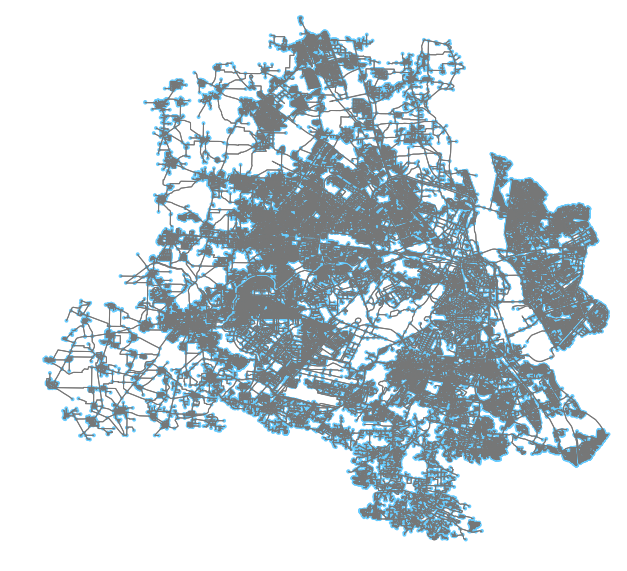

In [41]:
fig, ax = ox.plot_graph(area_graph, fig_height=10, 
                        show=False, close=False,
                        edge_color='#777777')

# Instead, let's first update the network with these new random POI

for point in hospital_pois:
    patch = PolygonPatch(point.buffer(0.0001), fc='#ff0000', ec='k', linewidth=0, alpha=0.5, zorder=-1)
    ax.add_patch(patch)

In [25]:
startpoint = (40.767937, -73.982155)
endpoint = (40.765602, -73.964630)

print (driving_distance(delhi_network, startpoint, endpoint))

0


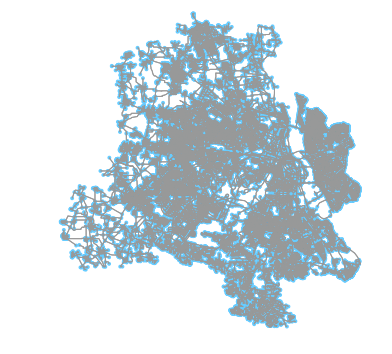

(<matplotlib.figure.Figure at 0x164547320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x164541c50>)

In [11]:
ox.plot_graph(delhi_network)